# Visual Analytics
### Load the Dataset

In [1]:
import os
import pandas as pd
import torch 
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
import kagglehub
import json
import pytorch_lightning as pl
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import shutil
import seaborn as sns

/Users/jayinnejal/VA2025/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jayinnejal/VA2025/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download dataset
src_path = kagglehub.dataset_download("adilshamim8/student-performance-and-learning-style")

# Set your target path
target_path = "./data/student-habits"

# Move the directory
if os.path.exists(target_path):
    shutil.rmtree(target_path)
shutil.copytree(src_path, target_path)

100%|██████████| 148k/148k [00:00<00:00, 528kB/s]

Extracting files...


'./data/student-habits'

In [3]:
# Load the data
df = pd.read_csv(os.path.join(target_path, "student_performance_large_dataset.csv"))
df.head()

,Student_ID,Age,Gender,Study_Hours_per_Week,Preferred_Learning_Style,Online_Courses_Completed,Participation_in_Discussions,Assignment_Completion_Rate (%),Exam_Score (%),Attendance_Rate (%),Use_of_Educational_Tech,Self_Reported_Stress_Level,Time_Spent_on_Social_Media (hours/week),Sleep_Hours_per_Night,Final_Grade
0,S00001,18,Female,48,Kinesthetic,14,Yes,100,69,66,Yes,High,9,8,C
1,S00002,29,Female,30,Reading/Writing,20,No,71,40,57,Yes,Medium,28,8,D
2,S00003,20,Female,47,Kinesthetic,11,No,60,43,79,Yes,Low,13,7,D
3,S00004,23,Female,13,Auditory,0,Yes,63,70,60,Yes,Low,24,10,B
4,S00005,19,Female,24,Auditory,19,Yes,59,63,93,Yes,Medium,26,8,C


### Exploratory Data Analysis

Summary of the dataset

In [4]:
df.describe(include='all') 

,Student_ID,Age,Gender,Study_Hours_per_Week,Preferred_Learning_Style,Online_Courses_Completed,Participation_in_Discussions,Assignment_Completion_Rate (%),Exam_Score (%),Attendance_Rate (%),Use_of_Educational_Tech,Self_Reported_Stress_Level,Time_Spent_on_Social_Media (hours/week),Sleep_Hours_per_Night,Final_Grade
count,10000,10000.000000,10000,10000.000000,10000,10000.000000,10000,10000.000000,10000.000000,10000.000000,10000,10000,10000.000000,10000.000000,10000
unique,10000,NaN,3,NaN,4,NaN,2,NaN,NaN,NaN,2,3,NaN,NaN,4
top,S00001,NaN,Female,NaN,Visual,NaN,Yes,NaN,NaN,NaN,Yes,Medium,NaN,NaN,A
freq,1,NaN,4846,NaN,2523,NaN,5996,NaN,NaN,NaN,7022,5015,NaN,NaN,2678
mean,NaN,23.478800,NaN,27.130300,NaN,10.007900,NaN,74.922000,70.188900,75.085100,NaN,NaN,14.936500,6.979300,NaN
std,NaN,3.461986,NaN,13.002547,NaN,6.136726,NaN,14.675437,17.649447,14.749251,NaN,NaN,9.022639,1.996965,NaN
min,NaN,18.000000,NaN,5.000000,NaN,0.000000,NaN,50.000000,40.000000,50.000000,NaN,NaN,0.000000,4.000000,NaN
25%,NaN,20.000000,NaN,16.000000,NaN,5.000000,NaN,62.000000,55.000000,62.000000,NaN,NaN,7.000000,5.000000,NaN
50%,NaN,23.000000,NaN,27.000000,NaN,10.000000,NaN,75.000000,70.000000,75.000000,NaN,NaN,15.000000,7.000000,NaN
75%,NaN,27.000000,NaN,38.000000,NaN,15.000000,NaN,88.000000,85.000000,88.000000,NaN,NaN,23.000000,9.000000,NaN


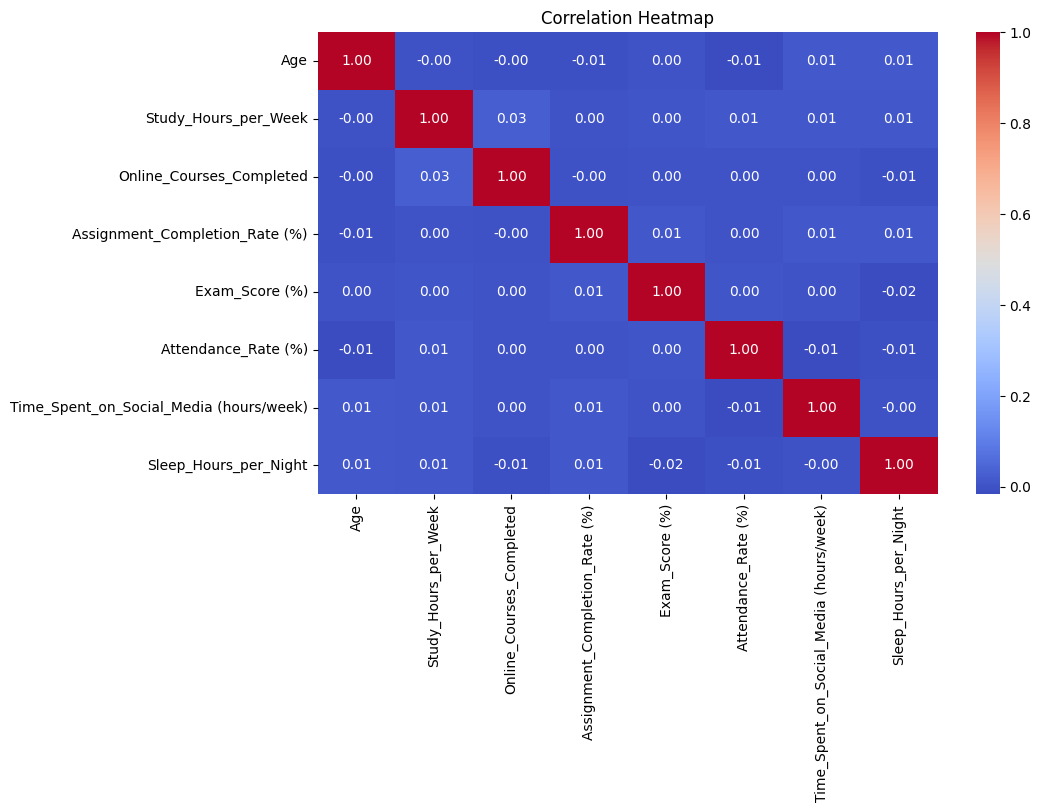

In [5]:
# Compute correlations
corr = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Check for outliers in the data

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

X = df[["study_hours_per_day", 
        "mental_health_rating", 
        "social_media_hours", 
        "netflix_hours", 
        "sleep_hours", 
        "exercise_frequency",
        "attendance_percentage"]]
y = df["exam_score"]

# For all numerical columns
for col in X.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=X[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

for col in X.columns:
    plt.figure(figsize=(5, 3))
    sns.scatterplot(x=X[col], y=y)
    plt.title(f'{col} vs Exam Score')
    plt.show()

KeyError: "None of [Index(['study_hours_per_day', 'mental_health_rating', 'social_media_hours',\n       'netflix_hours', 'sleep_hours', 'exercise_frequency',\n       'attendance_percentage'],\n      dtype='object')] are in the [columns]"